In [65]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
#import subprocess
import requests
import random
import json


print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.2.0


# Create a Simple Model

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


##  Train and evaluate your model

Let's use the simplest possible CNN, since we're not focused on the modeling part.

In [6]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5487 - accuracy: 0.8077
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4153 - accuracy: 0.8539
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3743 - accuracy: 0.8682
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.

## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [7]:
MODEL_DIR = os.getcwd() +"/model"
MODEL_NAME="model"
version = "01"
export_path = os.path.join(MODEL_DIR,version)
print('export_path = {}\n'.format(export_path))



export_path = /home/omer/Desktop/Works/docker_cellar/4-Tensorflow_Server/tf_serving/model/01



In [8]:
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/omer/Desktop/Works/docker_cellar/4-Tensorflow_Server/tf_serving/model/01/assets

Saved model:
total 84
drwxr-xr-x 2 omer omer  4096 Eyl 19 13:55 assets
-rw-rw-r-- 1 omer omer 76554 Eyl 19 13:55 saved_model.pb
drwxr-xr-x 2 omer omer  4096 Eyl 19 13:55 variables


# Serve your model with TensorFlow Serving  using Docker


### Start running TensorFlow Serving

This is where we start running TensorFlow Serving with Docker and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [10]:
os.environ["MODEL_DIR"] = MODEL_DIR
os.environ["MODEL_NAME"] = MODEL_NAME

## Make a API  via tensorflow/serving Docker image

**Adding docker container name**

In [52]:
container_name="tfs"
os.environ["CONTAINER_NAME"]=container_name


**Pull tensorflow/serving docker image**

In [ ]:
!docker pull tensorflow/serving

**Run tensorflow/serving container** 

In [62]:
%%bash --bg

docker run -t --rm --name "${CONTAINER_NAME}" -p 8501:8501 \
    -v "${MODEL_DIR}:/models/${MODEL_NAME}" \
    -e MODEL_NAME="${MODEL_NAME}" \
    tensorflow/serving &


**Check container is running**

In [63]:
!docker ps 

CONTAINER ID        IMAGE                COMMAND                  CREATED             STATUS                  PORTS                              NAMES
ae41db769667        tensorflow/serving   "/usr/bin/tf_serving…"   1 second ago        Up Less than a second   8500/tcp, 0.0.0.0:8501->8501/tcp   tfs


**Check continer is running without problem**

In [64]:
%%bash 
docker logs "${CONTAINER_NAME}"

2020-09-19 11:10:16.939155: I tensorflow_serving/model_servers/server.cc:87] Building single TensorFlow model file config:  model_name: model model_base_path: /models/model
2020-09-19 11:10:16.939277: I tensorflow_serving/model_servers/server_core.cc:464] Adding/updating models.
2020-09-19 11:10:16.939288: I tensorflow_serving/model_servers/server_core.cc:575]  (Re-)adding model: model
2020-09-19 11:10:17.040201: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: model version: 1}
2020-09-19 11:10:17.040274: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: model version: 1}
2020-09-19 11:10:17.040305: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: model version: 1}
2020-09-19 11:10:17.040401: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from: /models/model/01
2020-09-19 11:10:17.046706: I external/org_tensorflow/tensorfl

**If want to delete container**

In [ ]:
%%bash
docker rm "${CONTAINER_NAME}" -f 

# Send Data

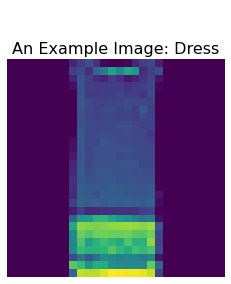

In [68]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})


rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [95]:

data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:13].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


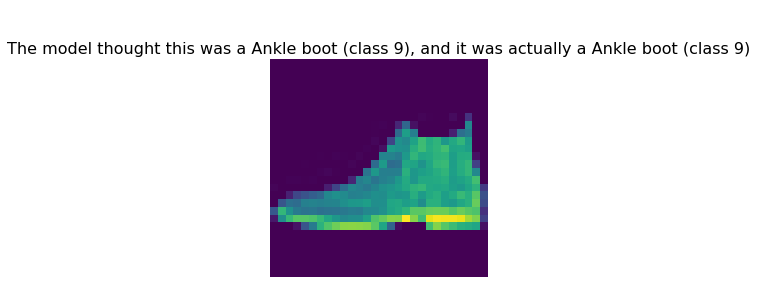

In [96]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

## Show results

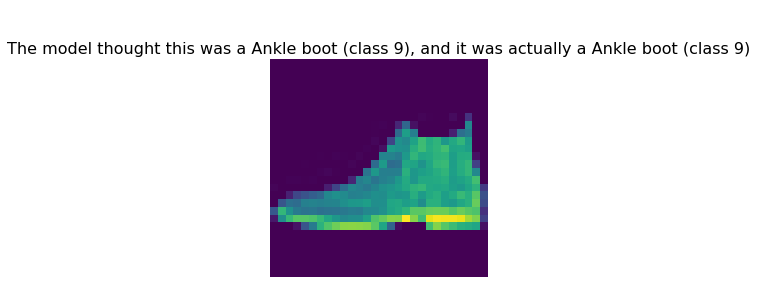

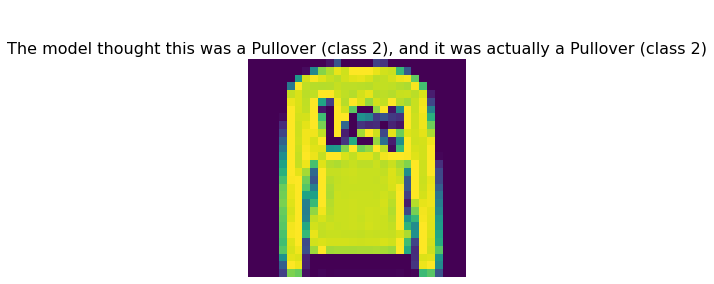

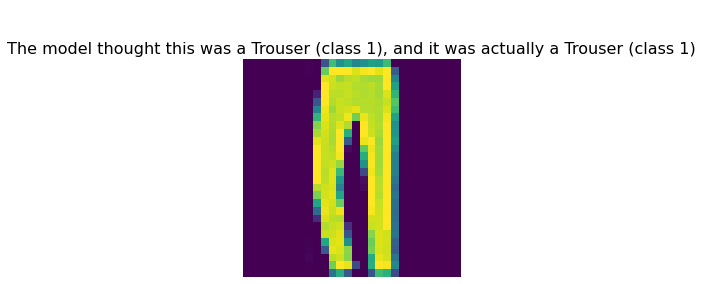

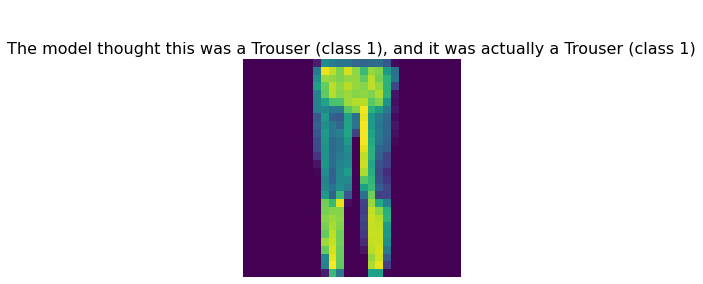

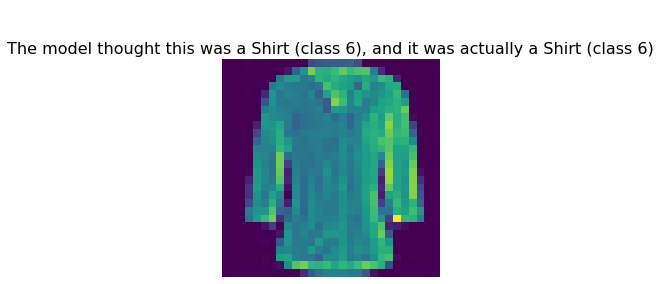

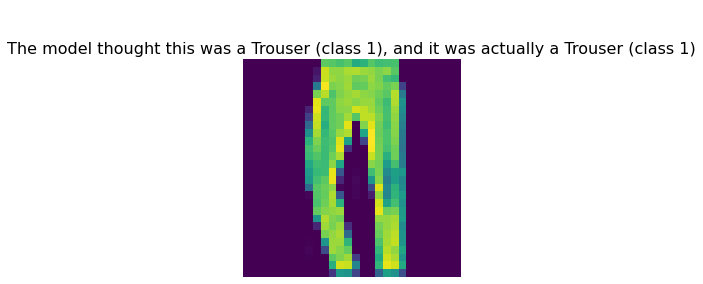

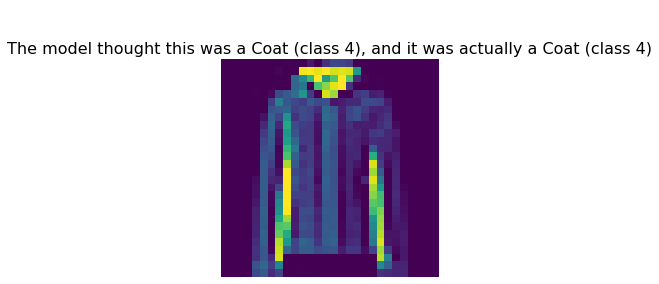

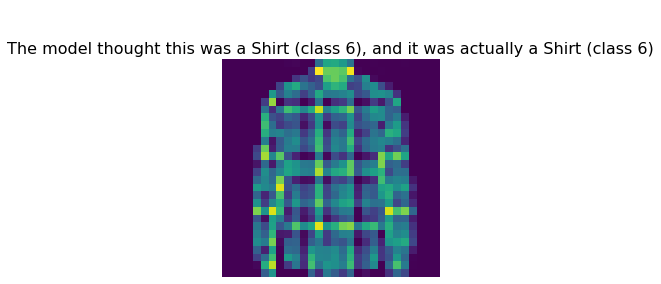

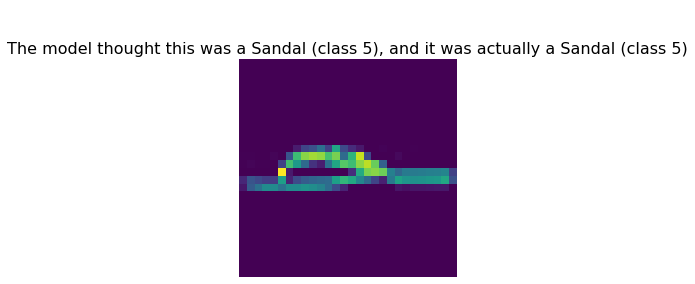

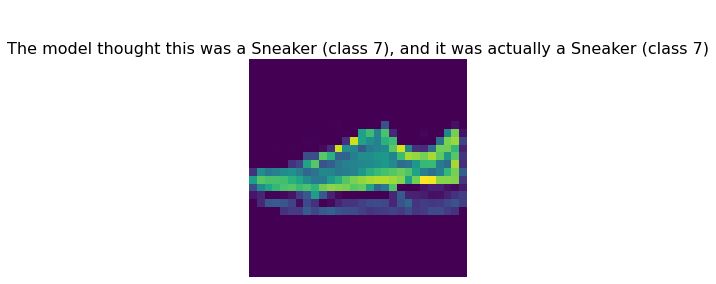

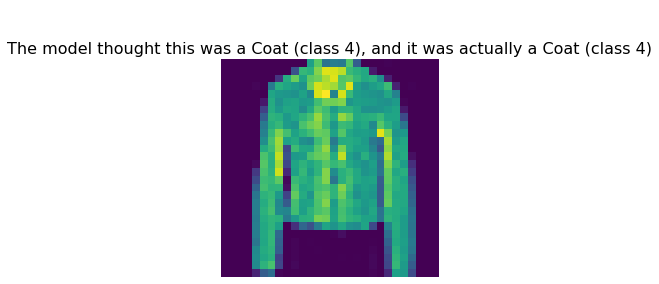

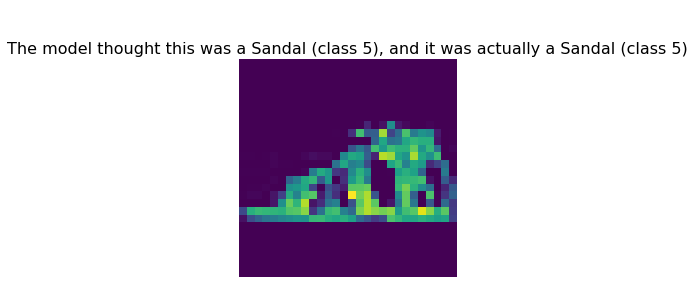

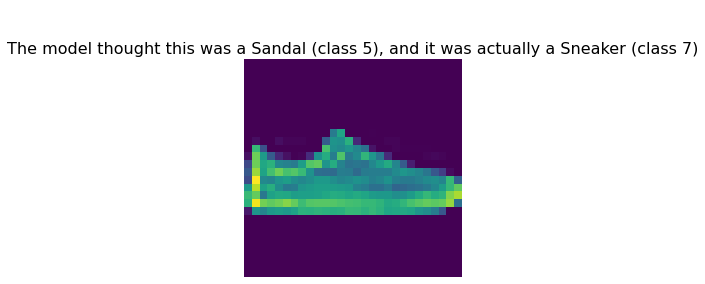

In [98]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,13):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))